## CSCE 676 :: Data Mining and Analysis :: Texas A&M University :: Spring 2026


# Weekly Homework 4: Graphs! Part 2


***Goals of this homework:***
Perform an analysis of a graph of your choice.


***Submission instructions:***

You should post your notebook to Canvas (look for the assignment there). Please name your submission **your-uin_hw3.ipynb**, so for example, my submission would be something like **555001234_hw3.ipynb**. Your notebook should be fully executed when you submit ... so run all the cells for us so we can see the output, then submit that.

***Grading philosophy:***

We are grading reasoning, judgment, and clarity, not just correctness. Show us that you understand the data, the constraints, and the limits of your conclusions.

***For each question, you need to respond with 2 cells:***
1. **[A Code Cell] Your Code:**
  - If code is not applicable for the question, you can skip this cell.
  - For tests: tests can be simple assertions or checks (e.g., using `assert` or `print` or small functions or visual inspection); formal testing frameworks are not required.
2. **[A Markdown Cell] Your Answer:** Write up your answers and explain them in complete sentences. Include any videos in this section as well; for videos, upload them to your TAMU Google Drive, and ensure they are set to be visible by the instruction team (set to: **anyone with a TAMU email can view**), then share the link to the video in the cell.

***At the end of each Section (A/B/C/...) include a cell for your resources:***

**[A Markdown Cell] Your Resources:** You need to cite 3 types of resources and note how they helped you: (1) Collaborators, (2) Web Sources (e.g. StackOverflow), and (3) AI Tools (you must also describe how you prompted, but we do not require any links to any specific chats). Specifically, use the following format as a template:
```
On my honor, I declare the following resources:
1. Collaborators:
- Reveille A.: Helped me understand that a df in pandas is a data structure kinda like a CSV.
- Sully A.: Helped me fix a bug with the vector addition of 2 columns.
- ...

2. Web Sources:
- https://stackoverflow.com/questions/46562479/python-pandas-data-frame-creation: how to create a pd df
- ...

3. AI Tools:
- ChatGPT: I gave it the homework .ipynb file and the ufo.csv, and told it to generate the code for the first question, but it did it with csv.reader(), so I re-prompted it to use pandas and that one was correct
- ...
```
***Why do we require this cell?*** This cell is important...

1. For academic integrity, you must give credit where credit is due.

2. We want you to pay attention to how you can successfully get help to move through problems! Is there someone you work with or an AI tool that helps you learn the material better? That's great! The point of engineering is to use your tools to solve hard problems, and part of graduate school is learning about how *you* learn and solve problems best.

***A reminder: you get out of it what you put into it.***
Do your best on these homeworks, show us your creativity, and ask for help when you need it -- good luck!

# A [72pts]. Step-by-Step Data Mining & Experimental Analysis on A Graph of Your Choice -- A Continuation of Last Week!

**Rubric**

[18 pts] Strong/Professional: Correct and complete implementation of the task; Reasonable assumptions, stated or implied, and justified; Thoughtful handling of real-world data issues (missingness, noise, scale, duplicates, edge cases); Clear, concise explanations of what was done and why; Code is clean, readable, and well-structured, uses appropriate pandas, and would plausibly pass a professional code review; Tests meaningfully validate non-trivial behavior (not just "the code runs so it must be right").

[9 pts] Partial/Developing: Core task mostly completed but with gaps, weak assumptions, or minor mistakes; Reasoning is shallow or mostly descriptive; Code works but is messy, repetitive, or fragile; Tests are superficial, incomplete, or poorly motivated.

[0 pts] Minimal/Incorrect: Task is largely incorrect, missing, or misunderstands the goal; Little to no reasoning or justification; Code does not run or ignores constraints; No meaningful tests.


## Overview
In this homework, you will **choose one dataset you like** from the [SNAP datasets](https://snap.stanford.edu/data/index.html) collection from the **Social networks** section. You must choose a  **directed graph only**. In this section, you will perform a step‑by‑step data mining & experimental analysis. *Much of this section is self-directed, meaning you will need to make critical decisions about what tools you use and what you explore.*

Ideally, you should eventually turn in a coherent story: **What you tried → Why → What you found → So what? → Wait...Anything more?**. It's completely OKAY if you only get minor discoveries. But you should always document the whole learning and reasoning process. Grading will be based on the logic and coherence of your submitted notebook.

As a guide, for each step of the homework, you should briefly document:
- **Method choice & rationale.** Why this method? What do you expect?
- **Parameters.** E.g., `alpha=0.85` for PageRank; seed selection for PPR; thresholds for community extraction.
- **Results.** Tables/plots + **1–3 sentences** of interpretation.
- **Reflection.** Did results match your expectations? If not, why might that be?

Ideally, strong submissions should read like a *short research memo* rather than a raw dump of numbers.

## Environment Setup
You may use **Python 3.9+**. Other possible tools are:
- **Graph tools**: You are welcome to use existing tools that are optimised for graph learning. Among them, `networkx`is recommended. `graph-tool` and `igraph` are also good when dealing with larger graphs.
- **Data processing packages**: eg. `numpy`, `pandas`
- **Plotting**: `matplotlib`, `plotly`, `seaborn` etc.
- **other related tools** `scipy`, `scikit-learn`,  `pytorch` etc.
- You may choose other tools; just be sure to let us know.

> If your chosen dataset is very large, consider using `graph-tool` and `igraph`, or sampling/induced subgraphs to stay within reasonable time/memory limits.


# 1. Centrality Analyses
First, you must compute
- **PageRank**
as a baseline centrality measure.

Then you should choose at least one of the following to compare with:

- **HITS** (hubs/authorities)
- **In-degree** and **out-degree** centrality (as baselines)
- **Katz** or **eigenvector** centrality on a symmetrized version

Create a small table of **top-20 nodes** by each measure and comment on overlaps/differences.


In [1]:
from __future__ import annotations

import argparse
import gzip
import io
import os
from pathlib import Path
from typing import Dict, Iterable, List, Sequence, Tuple

import pandas as pd
import requests
import igraph as ig


URL = "https://snap.stanford.edu/data/soc-Slashdot0902.txt.gz"
FILENAME = "soc-Slashdot0902.txt.gz"
gz_path = "../data/" + FILENAME

def download_if_needed(url: str, dest: str, chunk_size: int = 1 << 20) -> None:
    dest = Path(dest)
    dest.parent.mkdir(parents=True, exist_ok=True)
    if dest.exists() and dest.stat().st_size > 0:
        return

    print(f"[download] Fetching: {url}")
    with requests.get(url, stream=True, timeout=120) as r:
        r.raise_for_status()
        with open(dest, "wb") as f:
            for chunk in r.iter_content(chunk_size=chunk_size):
                if chunk:
                    f.write(chunk)
    print(f"[download] Saved to: {dest} ({dest.stat().st_size:,} bytes)")


def iter_edges_from_gz(path: Path) -> Iterable[Tuple[str, str]]:
    # File format: comment lines start with '#', edges are "src dst"
    with gzip.open(path, "rt", encoding="utf-8", newline="") as f:
        for line in f:
            if not line or line.startswith("#"):
                continue
            parts = line.split()
            if len(parts) != 2:
                continue
            yield parts[0], parts[1]


def build_graph(edges: Iterable[Tuple[str, str]]) -> ig.Graph:
    # TupleList creates vertex "name" attributes from IDs in edges.
    # Keep directed=True as dataset is directed.
    g = ig.Graph.TupleList(edges, directed=True, vertex_name_attr="name")
    # Remove self-loops and parallel edges (typical preprocessing)
    g.simplify(multiple=True, loops=True, combine_edges=None)
    return g


def top_n_table(
    g: ig.Graph, scores: Sequence[float], measure: str, top_n: int
) -> pd.DataFrame:
    names = g.vs["name"]
    order = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:top_n]
    rows = [{"measure": measure, "node": int(names[i]), "score": float(scores[i]), "rank": r + 1}
            for r, i in enumerate(order)]
    return pd.DataFrame(rows, columns=["measure", "rank", "node", "score"])


def compare_top_sets(tops: Dict[str, pd.DataFrame]) -> pd.DataFrame:
    # Pairwise overlap (intersection size + Jaccard)
    measures = list(tops.keys())
    top_sets = {m: set(tops[m]["node"].tolist()) for m in measures}

    rows = []
    for i in range(len(measures)):
        for j in range(i + 1, len(measures)):
            a, b = measures[i], measures[j]
            sa, sb = top_sets[a], top_sets[b]
            inter = sa & sb
            union = sa | sb
            rows.append({
                "A": a,
                "B": b,
                "intersection_count": len(inter),
                "jaccard": (len(inter) / len(union)) if union else 0.0,
                "common_nodes": sorted(inter)[:10],  # show a few to keep output compact
            })
    return pd.DataFrame(rows, columns=["A", "B", "intersection_count", "jaccard", "common_nodes"])

def construct_graph(gz_path):
    print("[load] Reading edges...")
    edges = list(iter_edges_from_gz(gz_path))
    print(f"[load] Raw edges read: {len(edges):,}")

    print("[graph] Building igraph directed graph...")
    g = build_graph(edges)
    return g

def problem_1():
  
    
    top = 20;
    
    download_if_needed(URL, gz_path)
    
    g = construct_graph(gz_path)
    n, m = g.vcount(), g.ecount()
    print(f"[graph] Vertices: {n:,}  Edges: {m:,}  (after simplify)")

    # --- Centrality computations (igraph) ---
    print("[compute] PageRank...")
    pr = g.pagerank(directed=True)

    print("[compute] HITS hub/authority scores...")
    hubs = g.hub_score()          # directed by default
    auth = g.authority_score()    # directed by default

    print("[compute] In-degree / Out-degree...")
    indeg = g.indegree()
    outdeg = g.outdegree()

    # --- Top-N tables ---
    tops: Dict[str, pd.DataFrame] = {}
    tops["PageRank"] = top_n_table(g, pr, "PageRank", top)
    tops["HITS_hub"] = top_n_table(g, hubs, "HITS_hub", top)
    tops["HITS_authority"] = top_n_table(g, auth, "HITS_authority", top)
    tops["InDegree"] = top_n_table(g, indeg, "InDegree", top)
    tops["OutDegree"] = top_n_table(g, outdeg, "OutDegree", top)

    print("\n=== Top-20 tables (by measure) ===")
    for measure, df in tops.items():
        print(f"\n--- {measure} ---")
        # make it readable in terminal
        print(df.to_string(index=False, justify="left", col_space=10, formatters={"score": "{:.6g}".format}))

    # --- Overlap / difference commentary ---
    overlap_df = compare_top_sets(tops)
    print("\n=== Overlaps among Top-N sets (intersection + Jaccard) ===")
    print(overlap_df.to_string(index=False, justify="left", col_space=12))

    # A short, human-readable commentary (heuristic / typical differences)
    pr_top = set(tops["PageRank"]["node"])
    hub_top = set(tops["HITS_hub"]["node"])
    auth_top = set(tops["HITS_authority"]["node"])
    indeg_top = set(tops["InDegree"]["node"])
    outdeg_top = set(tops["OutDegree"]["node"])

    print("\n=== Commentary (quick read) ===")
    print(
        "- PageRank tends to favor nodes that receive links from other well-linked nodes\n"
        "  (global prestige / influence).\n"
        "- HITS splits roles:\n"
        "  * Authorities: nodes pointed to by strong hubs (often similar to high in-degree, but weighted).\n"
        "  * Hubs: nodes that point to many good authorities (often similar to high out-degree, but weighted).\n"
        "- In/Out-degree are simple baselines: purely local counts with no recursive weighting.\n"
    )

    print(f"Top-{top} overlap counts vs PageRank:")
    print(f"  PageRank ∩ HITS_authority: {len(pr_top & auth_top)}")
    print(f"  PageRank ∩ HITS_hub:       {len(pr_top & hub_top)}")
    print(f"  PageRank ∩ InDegree:       {len(pr_top & indeg_top)}")
    print(f"  PageRank ∩ OutDegree:      {len(pr_top & outdeg_top)}")

    # Show a few common nodes to illustrate overlap
    common_auth = sorted(pr_top & auth_top)[:10]
    common_indeg = sorted(pr_top & indeg_top)[:10]
    common_hub = sorted(pr_top & hub_top)[:10]
    common_outdeg = sorted(pr_top & outdeg_top)[:10]

    print("\nExample common nodes (first few):")
    print(f"  PageRank & HITS_authority: {common_auth}")
    print(f"  PageRank & InDegree:       {common_indeg}")
    print(f"  PageRank & HITS_hub:       {common_hub}")
    print(f"  PageRank & OutDegree:      {common_outdeg}")

    print("\nDone.")

problem_1()


[load] Reading edges...
[load] Raw edges read: 948,464
[graph] Building igraph directed graph...
[graph] Vertices: 82,168  Edges: 870,161  (after simplify)
[compute] PageRank...
[compute] HITS hub/authority scores...


/var/folders/99/q6jxjyj9617_wy2l0435c4r00000gn/T/ipykernel_72313/2081169850.py:112: RuntimeWarning: More than 30% of hub or authority scores are zeros. The presence of zero values indicates that the solution is not unique, thus the returned result may not be meaningful. Location: src/centrality/hub_authority.c:81
  hubs = g.hub_score()          # directed by default
/var/folders/99/q6jxjyj9617_wy2l0435c4r00000gn/T/ipykernel_72313/2081169850.py:113: RuntimeWarning: More than 30% of hub or authority scores are zeros. The presence of zero values indicates that the solution is not unique, thus the returned result may not be meaningful. Location: src/centrality/hub_authority.c:81
  auth = g.authority_score()    # directed by default


[compute] In-degree / Out-degree...

=== Top-20 tables (by measure) ===

--- PageRank ---
measure     rank       node      score      
PageRank    1          2494       0.00273194
PageRank    2           398       0.00252651
PageRank    3           381       0.00236492
PageRank    4          4805       0.00181652
PageRank    5            37       0.00181183
PageRank    6           226       0.00152338
PageRank    7          5706       0.00137247
PageRank    8          4826       0.00110501
PageRank    9           219       0.00100132
PageRank   10          5057      0.000895077
PageRank   11          5513      0.000859242
PageRank   12          2828      0.000850472
PageRank   13          3482      0.000849135
PageRank   14          9190      0.000797863
PageRank   15            49      0.000791423
PageRank   16          5383      0.000735466
PageRank   17         13004       0.00073495
PageRank   18          2483      0.000728981
PageRank   19          5685      0.000674163
PageRank  

From the tables, we can see there is quite a large overlap between the top PageRank nodes and the top InDegree nodes. In fact, there is only one node that appears in the top 20 page rank table, but doesn't appear in the top 20 in degree table. There is a similar level of overlap with the out degree table.  
We also see that there isn't much overlap with the top page rank nodes and the top HITS nodes.

# 2. Connectivity Structure
- Count SCCs and WCCs; inspect the **giant SCC**.

- Pick 1–3 **representative SCCs** (by size) and compute internal stats (e.g., degree, density, average path length if feasible).

- Discuss what you observe about the structure of this subgraph.


In [2]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Tuple

import igraph as ig


@dataclass
class ComponentSummary:
    kind: str  # "SCC" or "WCC"
    n_components: int
    giant_size: int
    giant_fraction: float
    size_histogram_top: List[Tuple[int, int]]  # (component_size, count), top few
    sizes_desc: List[int]  # full sizes sorted desc (can be large; keep if you want)


@dataclass
class SCCInternalStats:
    scc_rank_by_size: int  # 1 = largest
    size: int
    density: float
    avg_in_degree: float
    avg_out_degree: float
    avg_total_degree: float
    reciprocity: Optional[float]  # None if not meaningful / fails
    avg_path_length: Optional[float]  # None if not feasible / fails
    diameter: Optional[int]  # None if not feasible / fails


def _top_histogram(sizes: List[int], top_k: int = 10) -> List[Tuple[int, int]]:
    # returns top_k most frequent sizes, tie-broken by size desc
    from collections import Counter

    c = Counter(sizes)
    items = sorted(c.items(), key=lambda x: (x[1], x[0]), reverse=True)
    return items[:top_k]


def count_components_and_giant_scc(g: ig.Graph) -> Dict[str, ComponentSummary]:
    """
    Count SCCs and WCCs and summarize component size distribution.
    Also identifies the giant SCC size/fraction (largest strongly connected component).

    Returns dict with keys: "SCC", "WCC".
    """
    if not g.is_directed():
        raise ValueError("Expected a directed graph for SCC analysis.")

    # Strongly connected components
    scc = g.components(mode="STRONG")
    scc_sizes = scc.sizes()
    scc_sizes_desc = sorted(scc_sizes, reverse=True)
    giant_scc_size = scc_sizes_desc[0] if scc_sizes_desc else 0

    # Weakly connected components
    wcc = g.components(mode="WEAK")
    wcc_sizes = wcc.sizes()
    wcc_sizes_desc = sorted(wcc_sizes, reverse=True)
    giant_wcc_size = wcc_sizes_desc[0] if wcc_sizes_desc else 0

    n = g.vcount() or 1  # avoid div-by-zero

    return {
        "SCC": ComponentSummary(
            kind="SCC",
            n_components=len(scc_sizes),
            giant_size=giant_scc_size,
            giant_fraction=giant_scc_size / n,
            size_histogram_top=_top_histogram(scc_sizes, top_k=10),
            sizes_desc=scc_sizes_desc,
        ),
        "WCC": ComponentSummary(
            kind="WCC",
            n_components=len(wcc_sizes),
            giant_size=giant_wcc_size,
            giant_fraction=giant_wcc_size / n,
            size_histogram_top=_top_histogram(wcc_sizes, top_k=10),
            sizes_desc=wcc_sizes_desc,
        ),
    }


def extract_giant_scc(g: ig.Graph) -> ig.Graph:
    """
    Return the induced subgraph corresponding to the giant (largest) SCC.
    Keeps vertex attributes (including 'name' if present).
    """
    if not g.is_directed():
        raise ValueError("Expected a directed graph.")
    scc = g.components(mode="STRONG")
    if scc.giant() is None or g.vcount() == 0:
        return g.subgraph([])  # empty graph
    return scc.giant()  # igraph returns the subgraph directly


def _safe_reciprocity(h: ig.Graph) -> Optional[float]:
    """
    Reciprocity is meaningful for directed graphs; igraph has a reciprocity() method
    in recent versions. If unavailable or fails, return None.
    """
    if not h.is_directed() or h.ecount() == 0:
        return None
    try:
        # igraph API differs across versions; try method then fallback
        if hasattr(h, "reciprocity"):
            return float(h.reciprocity())
    except Exception:
        pass
    return None


def _path_stats_if_feasible(
    h: ig.Graph,
    max_vertices: int = 5000,
    max_edges: int = 200000,
    directed: bool = True,
) -> Tuple[Optional[float], Optional[int]]:
    """
    Average path length and diameter can be expensive.
    Compute only if size is reasonable; otherwise return (None, None).
    For SCCs, directed paths are well-defined; you can set directed=False if desired.

    Note: For very large SCCs this can still be expensive.
    """
    if h.vcount() == 0:
        return None, None
    if h.vcount() > max_vertices or h.ecount() > max_edges:
        return None, None

    try:
        apl = float(h.average_path_length(directed=directed, unconn=False))
    except Exception:
        apl = None

    try:
        diam = int(h.diameter(directed=directed, unconn=False))
    except Exception:
        diam = None

    return apl, diam


def pick_representative_sccs(
    g: ig.Graph,
    ranks_by_size: List[int] = [1, 2, 5],
    min_size: int = 10,
) -> List[ig.Graph]:
    """
    Pick 1–3 representative SCCs by size rank (1 = largest).
    Filters out SCCs smaller than min_size. Returns subgraphs.

    Example:
      reps = pick_representative_sccs(g, ranks_by_size=[1, 3, 10], min_size=50)
    """
    if not g.is_directed():
        raise ValueError("Expected a directed graph.")

    scc = g.components(mode="STRONG")
    sizes = scc.sizes()
    if not sizes:
        return []

    # Get SCC indices sorted by size desc
    order = sorted(range(len(sizes)), key=lambda i: sizes[i], reverse=True)

    selected: List[ig.Graph] = []
    for r in ranks_by_size:
        idx_in_order = r - 1
        if idx_in_order < 0 or idx_in_order >= len(order):
            continue
        comp_idx = order[idx_in_order]
        if sizes[comp_idx] < min_size:
            continue
        verts = scc[comp_idx]  # vertex indices in this SCC
        selected.append(g.subgraph(verts))

        if len(selected) >= 3:
            break

    return selected


def compute_scc_internal_stats(
    scc_subgraph: ig.Graph,
    scc_rank_by_size: int,
    path_stats: bool = True,
    path_max_vertices: int = 5000,
    path_max_edges: int = 200000,
) -> SCCInternalStats:
    """
    Compute internal stats for a given SCC subgraph:
      - size
      - density
      - average in/out/total degree
      - reciprocity (if available)
      - average path length + diameter (if feasible)

    Assumes scc_subgraph is strongly connected (but doesn't enforce).
    """
    n = scc_subgraph.vcount()
    m = scc_subgraph.ecount()

    indeg = scc_subgraph.indegree() if n else []
    outdeg = scc_subgraph.outdegree() if n else []
    totaldeg = scc_subgraph.degree(mode="ALL") if n else []

    density = float(scc_subgraph.density(loops=False)) if n else 0.0

    reciprocity = _safe_reciprocity(scc_subgraph)

    apl, diam = (None, None)
    if path_stats:
        apl, diam = _path_stats_if_feasible(
            scc_subgraph,
            max_vertices=path_max_vertices,
            max_edges=path_max_edges,
            directed=True,
        )

    return SCCInternalStats(
        scc_rank_by_size=scc_rank_by_size,
        size=n,
        density=density,
        avg_in_degree=(sum(indeg) / n) if n else 0.0,
        avg_out_degree=(sum(outdeg) / n) if n else 0.0,
        avg_total_degree=(sum(totaldeg) / n) if n else 0.0,
        reciprocity=reciprocity,
        avg_path_length=apl,
        diameter=diam,
    )


def summarize_scc_structure(
    scc_stats: List[SCCInternalStats],
    global_scc_summary: Optional[ComponentSummary] = None,
) -> str:
    """
    Produce a short narrative based on SCC internal stats and optional global SCC summary.
    You can print/attach this to a report.

    This is heuristic commentary—not a proof.
    """
    lines: List[str] = []

    if global_scc_summary is not None:
        lines.append(
            f"The directed graph contains {global_scc_summary.n_components:,} SCCs. "
            f"The giant SCC has {global_scc_summary.giant_size:,} nodes "
            f"({global_scc_summary.giant_fraction:.2%} of all nodes)."
        )

    if not scc_stats:
        lines.append("No SCCs met the selection criteria (or the graph is empty).")
        return "\n".join(lines)

    # Sort by rank (1 = largest)
    scc_stats_sorted = sorted(scc_stats, key=lambda x: x.scc_rank_by_size)

    for st in scc_stats_sorted:
        tag = f"SCC rank #{st.scc_rank_by_size}"
        lines.append(
            f"{tag}: size={st.size:,}, density={st.density:.6g}, "
            f"avg_in={st.avg_in_degree:.3g}, avg_out={st.avg_out_degree:.3g}, "
            f"avg_total={st.avg_total_degree:.3g}"
            + (f", reciprocity={st.reciprocity:.3g}" if st.reciprocity is not None else "")
            + (f", avg_path_len={st.avg_path_length:.3g}, diam={st.diameter}"
               if st.avg_path_length is not None and st.diameter is not None else
               ", path stats skipped/too expensive")
        )

    

    return "\n".join(lines)
def test_case_1_two_cycles_plus_isolate():
    """
    Graph:
      - SCC A: 0->1->2->0 (size 3)
      - SCC B: 3<->4 (size 2)
      - SCC C: 5 alone (size 1)
    Weakly connected components:
      - {0,1,2} size 3
      - {3,4} size 2
      - {5} size 1
    """
    g = ig.Graph(directed=True)
    g.add_vertices(6)
    g.add_edges([
        (0, 1), (1, 2), (2, 0),   # 3-cycle
        (3, 4), (4, 3),           # 2-cycle
        # vertex 5 isolated
    ])

    summaries = count_components_and_giant_scc(g)
    print("Summaries:", summaries)

    # SCC summary checks
    scc_sum = summaries["SCC"]
    assert scc_sum.n_components == 3, f"Expected 3 SCCs, got {scc_sum.n_components}"
    assert scc_sum.giant_size == 3, f"Expected giant SCC size 3, got {scc_sum.giant_size}"
    assert abs(scc_sum.giant_fraction - (3/6)) < 1e-12

    # WCC summary checks
    wcc_sum = summaries["WCC"]
    assert wcc_sum.n_components == 3, f"Expected 3 WCCs, got {wcc_sum.n_components}"
    assert wcc_sum.giant_size == 3, f"Expected giant WCC size 3, got {wcc_sum.giant_size}"

    # Giant SCC extraction
    giant = extract_giant_scc(g)
    print("Giant SCC vcount/ecount:", giant.vcount(), giant.ecount())
    assert giant.vcount() == 3, f"Expected giant SCC to have 3 vertices, got {giant.vcount()}"

    # Representative SCC picking: ranks 1..3 with min_size=0 should return all 3 SCCs
    reps = pick_representative_sccs(g, ranks_by_size=[1, 2, 3], min_size=0)
    rep_sizes = [h.vcount() for h in reps]
    print("Representative SCC sizes:", rep_sizes)
    assert rep_sizes == [3, 2, 1], f"Expected [3,2,1], got {rep_sizes}"

    # Internal stats sanity for the largest SCC (3-cycle)
    st = compute_scc_internal_stats(reps[0], scc_rank_by_size=1, path_stats=True)
    print("Largest SCC stats:", st)

    assert st.size == 3
    assert abs(st.avg_in_degree - 1.0) < 1e-12
    assert abs(st.avg_out_degree - 1.0) < 1e-12
    assert abs(st.avg_total_degree - 2.0) < 1e-12
    # In a directed 3-cycle, average path length is 1.5 and diameter is 2 (directed shortest paths)
    if st.avg_path_length is not None:
        assert abs(st.avg_path_length - 1.5) < 1e-12, f"Expected APL 1.5, got {st.avg_path_length}"
    if st.diameter is not None:
        assert st.diameter == 2, f"Expected diam 2, got {st.diameter}"

    print("test_case_1_two_cycles_plus_isolate: PASS")


def test_case_2_one_big_scc_with_tail():
    """
    Graph:
      - Big SCC: 0,1,2,3 form a strongly-connected 4-node component
      - Tail: 3 -> 4 -> 5 (no edges back), so {4}, {5} are singleton SCCs
    Weakly connected components: all nodes connected (size 6) because direction ignored.
    """
    g = ig.Graph(directed=True)
    g.add_vertices(6)

    # Make 0-1-2-3 strongly connected (cycle) plus some extra edges
    g.add_edges([
        (0, 1), (1, 2), (2, 3), (3, 0),  # 4-cycle => SCC size 4
        (0, 2),                           # chord
        (3, 4), (4, 5)                    # tail out of SCC
    ])

    summaries = count_components_and_giant_scc(g)
    print("Summaries:", summaries)

    scc_sum = summaries["SCC"]
    wcc_sum = summaries["WCC"]

    # SCC: {0,1,2,3} plus {4} plus {5} => 3 SCCs
    assert scc_sum.n_components == 3, f"Expected 3 SCCs, got {scc_sum.n_components}"
    assert scc_sum.giant_size == 4, f"Expected giant SCC size 4, got {scc_sum.giant_size}"
    assert abs(scc_sum.giant_fraction - (4/6)) < 1e-12

    # WCC: direction ignored => everything is connected via 3-4-5, so 1 WCC of size 6
    assert wcc_sum.n_components == 1, f"Expected 1 WCC, got {wcc_sum.n_components}"
    assert wcc_sum.giant_size == 6, f"Expected giant WCC size 6, got {wcc_sum.giant_size}"
    assert abs(wcc_sum.giant_fraction - 1.0) < 1e-12

    giant = extract_giant_scc(g)
    print("Giant SCC vcount/ecount:", giant.vcount(), giant.ecount())
    assert giant.vcount() == 4, f"Expected giant SCC to have 4 vertices, got {giant.vcount()}"

    # Pick reps: rank 1 is size 4; ranks 2/3 are singletons
    reps = pick_representative_sccs(g, ranks_by_size=[1, 2, 3], min_size=0)
    rep_sizes = [h.vcount() for h in reps]
    print("Representative SCC sizes:", rep_sizes)
    assert rep_sizes[0] == 4
    assert sorted(rep_sizes[1:]) == [1, 1]

    # Basic internal stats on the big SCC
    st = compute_scc_internal_stats(reps[0], scc_rank_by_size=1, path_stats=True)
    print("Big SCC stats:", st)
    assert st.size == 4
    assert st.avg_in_degree > 0
    assert st.avg_out_degree > 0
    assert st.avg_total_degree > 0

    print("test_case_2_one_big_scc_with_tail: PASS")

test_case_1_two_cycles_plus_isolate()
test_case_2_one_big_scc_with_tail()

def problem2():
    g = construct_graph(gz_path)
    summaries = count_components_and_giant_scc(g)
    giant = extract_giant_scc(g)
    
    rep_sccs = pick_representative_sccs(g, ranks_by_size=[1, 2, 3], min_size=0)
    
    stats = []
    for i, sub in enumerate(rep_sccs, start=1):
        stats.append(compute_scc_internal_stats(sub, scc_rank_by_size=i, path_stats=True))
    
    commentary = summarize_scc_structure(stats, global_scc_summary=summaries["SCC"])
    print(commentary)

problem2()

Summaries: {'SCC': ComponentSummary(kind='SCC', n_components=3, giant_size=3, giant_fraction=0.5, size_histogram_top=[(3, 1), (2, 1), (1, 1)], sizes_desc=[3, 2, 1]), 'WCC': ComponentSummary(kind='WCC', n_components=3, giant_size=3, giant_fraction=0.5, size_histogram_top=[(3, 1), (2, 1), (1, 1)], sizes_desc=[3, 2, 1])}
Giant SCC vcount/ecount: 3 3
Representative SCC sizes: [3, 2, 1]
Largest SCC stats: SCCInternalStats(scc_rank_by_size=1, size=3, density=0.5, avg_in_degree=1.0, avg_out_degree=1.0, avg_total_degree=2.0, reciprocity=0.0, avg_path_length=1.5, diameter=2)
test_case_1_two_cycles_plus_isolate: PASS
Summaries: {'SCC': ComponentSummary(kind='SCC', n_components=3, giant_size=4, giant_fraction=0.6666666666666666, size_histogram_top=[(1, 2), (4, 1)], sizes_desc=[4, 1, 1]), 'WCC': ComponentSummary(kind='WCC', n_components=1, giant_size=6, giant_fraction=1.0, size_histogram_top=[(6, 1)], sizes_desc=[6])}
Giant SCC vcount/ecount: 4 5
Representative SCC sizes: [4, 1, 1]
Big SCC stats: 

We observed the following:  
- The largest SCC contains approximately 90% of all nodes
- The largest SCC is not very dense, but has high reciprocity
- The largest SCC is several orders of magnitude greater than the next largest SCC in terms of size
- The other SCCs have much higher density, but this is probably just because of the differences in size

Thus we have a very sparsely connected SCC with tens of thousands of nodes where most nodes have mutual edges to one another. All other SCCs in the graph contain less than 10 nodes, and thus don't carry much meaning since high density is quite easy to achieve with fewer nodes. 

# 3. Local Community via Personalized PageRank (PPR)
Pick a **seed node** (e.g., top PageRank, or a node of interest). Compute **personalized PageRank** with a restart vector focused on that node (or a small seed set).

- Extract a **local community** by thresholding PPR scores (e.g., top-`k` or score ≥ τ).
- Visualize the induced subgraph and **describe** the community's characteristics.
- Compare with a baseline (e.g., ego‑net, or Louvain on a symmetrized graph).

[load] Reading edges...
[load] Raw edges read: 948,464
[graph] Building igraph directed graph...


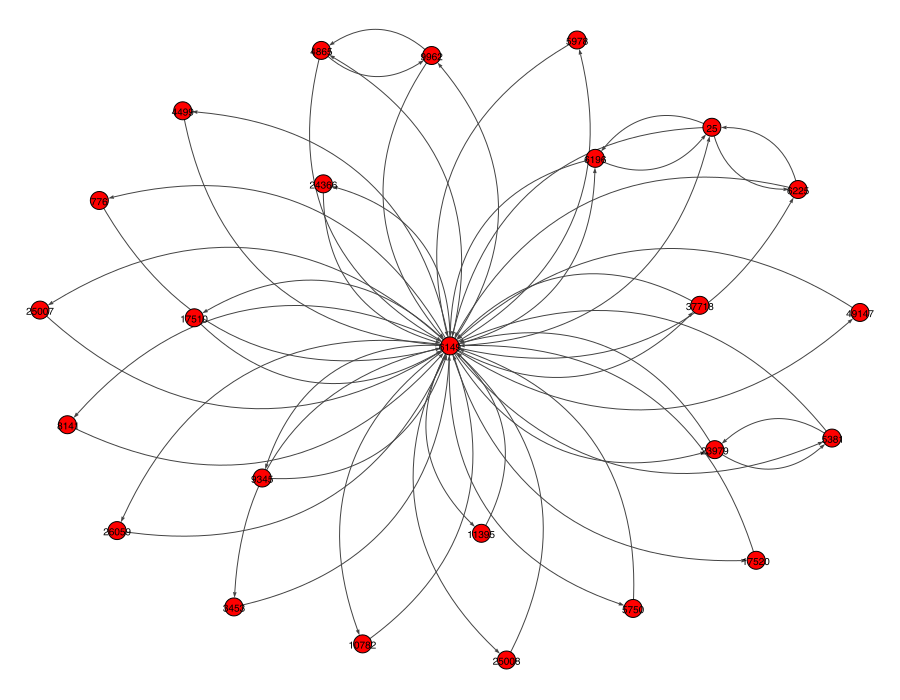

conductance:  0.9707581227436823
ego conductance:  0.9678686183505891


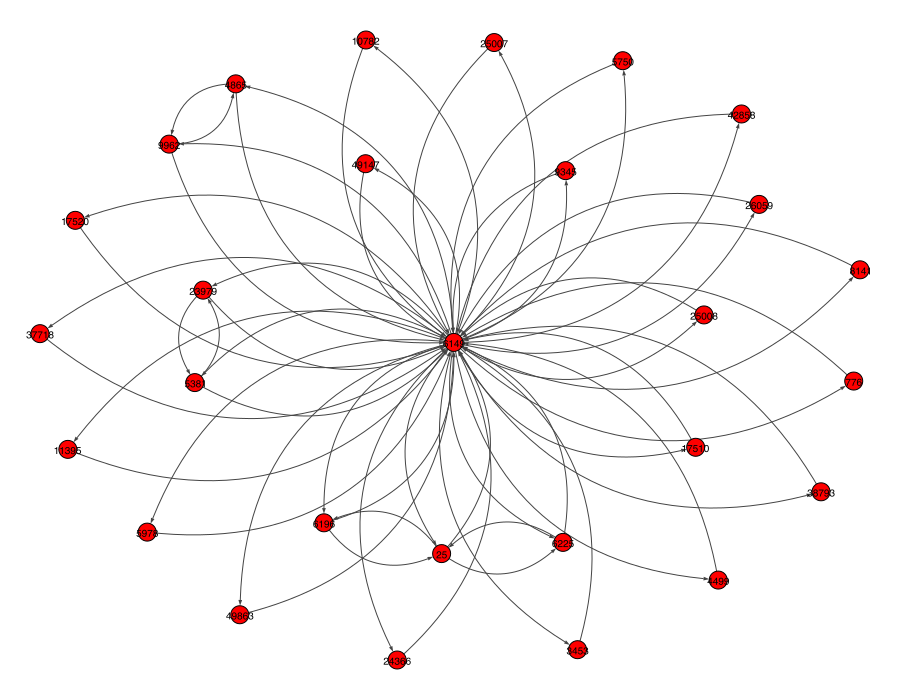

In [23]:
from IPython.display import display
%matplotlib inline

def find_seed_node(g):
    page_ranks = g.pagerank()
    table = top_n_table(g, page_ranks, "PageRank", 1)
    return table.iloc[0]["node"];
    
def ego_net(g, seed, hops=1):
    nodes = set([seed])
    frontier = set([seed])

    for _ in range(hops):
        next_frontier = set()
        for v in frontier:
            neigh = g.neighborhood(v, mode="out")
            next_frontier.update(neigh)
        nodes.update(next_frontier)
        frontier = next_frontier

    return list(nodes)

def find_conductance(subgraph_vertices, g): 

    cut = 0
    volume = 0
    for vertex in subgraph_vertices:
        vertex_neighbors = g.neighborhood(vertex, mode="out")
        for neighbor in vertex_neighbors:
            if not (neighbor in subgraph_vertices):
                cut += 1
            volume += 1
    
    return cut / volume

def plot_graph(induced_subgraph, k):
    # --- Plot ---
    layout = induced_subgraph.layout("fr")  # Fruchterman-Reingold

    # If you have vertex names, show them; otherwise don't label
    if "name" in induced_subgraph.vs.attributes():
        induced_subgraph.vs["label"] = induced_subgraph.vs["name"]
    else:
        induced_subgraph.vs["label"] = [str(v.index) for v in induced_subgraph.vs]

    # Make it readable (small-ish labels if k is large)
    visual_style = {
        "layout": layout,
        "vertex_size": 18,
        "vertex_label_size": 10 if k <= 50 else 6,
        "edge_arrow_size": 0.4,
        "bbox": (900, 700),
        "margin": 40,
    }

    plot = ig.plot(induced_subgraph, **visual_style)
    display(plot)
    
def problem3(k: int):
    g = construct_graph(gz_path)
    seed_node = find_seed_node(g)
    personalized_page_ranks = g.personalized_pagerank(reset_vertices=[seed_node])
    pagerank_vertex_pairs = [[personalized_page_ranks[i], i] for i in range(0, len(personalized_page_ranks))]
    sorted_page_rank = sorted(pagerank_vertex_pairs, key = lambda item: item[0], reverse= True)
    top_k_nodes = [value[1] for value in sorted_page_rank[0:k]]

    induced_subgraph = g.induced_subgraph(top_k_nodes)
    plot_graph(induced_subgraph, k)
    
    conductance = find_conductance(top_k_nodes, g)
    print("conductance: ", conductance)

    ego_net_cluster = ego_net(g, seed_node)
    ego_conductance = find_conductance(ego_net_cluster, g)
    print("ego conductance: ", ego_conductance)
    ego_induced_subgraph = g.induced_subgraph(ego_net_cluster)
    plot_graph(ego_induced_subgraph, k = ego_induced_subgraph.vcount())
    
problem3(k = 25)

From the visualization of the induced subgraph of the top 25 nodes by personalized pagerank, we can see that all of the nodes are connected to the central node (the node that we chose as our reset vector) however there aren't many connections between nodes that aren't the central node. This, along with the fact that the conductance is .97, implies that this is not a very good cluster. It is likely that the personalized page rank node is connected to many different clusters.  
The subgraph generated from top k page rank is nearly identical to the ego net graph, and the conductance is not much different (.971 vs .968).


# 4. Choose‑Your‑Own

For this last problem, you should complete **any one of the listed tasks**.

The tasks are:

A) **Link Prediction (directed)**: Create train/test splits by removing a subset of edges, then predict likely edges using features such as *Common Neighbors* (on symmetrized graph), *Jaccard*, *Adamic‑Adar*, *Preferential Attachment*, or **Katz** scores. Evaluate with **AUC / Precision@k**.

B) **HITS vs PageRank**: Compare top authorities/hubs with PageRank. When do they diverge? Provide examples and reasoning.

C) **Temporal or Reciprocity Analysis** (if timestamps exist): Examine edge reciprocity patterns over degree buckets. Hypothesize causality or social/semantic mechanisms.

D) **LSH/MinHash for neighborhood similarity**: For large graphs, sketch node neighborhoods and retrieve near‑duplicates (high Jaccard). Assess quality and speed vs exact Jaccard.

E) **Bow‑tie Decomposition** (web‑like graphs): Partition nodes into IN/SCC/OUT/tendrils and visualize proportions.

F) **Scaling**: For big graphs, compare `networkx` vs `igraph` runtime/memory on PageRank.


# B [24pts]. Interview Questions

We now pretend this is a real job interview. Here's some guidance on how to answer these questions:

1. Briefly restate the question and state any assumptions you are making.

2. Explain your reasoning out loud, focusing on tradeoffs, limitations, and constraints.

3. As a principle, keep your answers as short and clear as they can be (while still answering the question).

4. Write/speak in a conversational but professional tone (avoid being overly formal). For speaking: speak at a reasonable pace and volume, speak clearly, pause when you need to, and practice making "eye contact" with the camera. Keep a confident, positive, and professional tone. *For additional coaching and practice, the University Writing Center provides individual appointments: https://writingcenter.tamu.edu/make-an-appointment.*

There may not be a single correct answer. We are grading whether your reasoning is reasonable and aware of limitations.


**Rubric**

[8pt] Clear understanding of the question; reasonable assumptions; thoughtful reasoning that acknowledges tradeoffs and limitations; clear, concise communication in a conversational but professional tone (for speaking: clear pace, volume, and articulation).

[4pt] Basic understanding but shallow reasoning or unclear assumptions; communication is somewhat unclear, overly verbose, or overly informal/formal.

[0pt] Minimal, unclear, or incorrect response; poor communication or unprofessional tone.

# 1.
Explain "random walks" to me -- what do they do, why do we use them algorithmically, when would we use them?


# 2.
The notion of a “community” is defined structurally as dense internal connectivity and sparse external connectivity. What real-world phenomena does this definition capture well, and what important types of communities does it fail to capture?

# 3.
As a video (reminder to keep it brief): So, I see you did a graph analysis (referring to this homework). That's cool -- can you walk me through what you did?

# C [4pts]. What new questions do you have?
We want you to think bigger! Tell us what questions and curiosity this homework brings up for you.

**Rubric**

[4pt] Complete, thoughtful response.

[2pt] Partial response.

[0pt] Minimal response.

# 1.
What new questions do you have? Or, what topics are you curious about now? List at least 3.